In [27]:
import generator

import numpy as np

import matplotlib.pyplot as plt

from skopt.plots import plot_gaussian_process
from skopt import Optimizer

In [28]:
bins_file = open('../exp_data/na49/binning.bin', 'r')

In [29]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

In [30]:
import pandas as pd

ids = [211]

refs = {}

for id in ids:
    
    refs[id] = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [31]:
inst = {
    'Print:quiet': 'on',

    'Beams:frameType': '2',

    'Beams:idA': '2212',
    'Beams:idB': '2212',

    'Beams:eA': '158',
    'Beams:eB': '0',

    'SoftQCD:all': 'on',

    'Tune:pp': '1',

    'SigmaDiffractive:dampen': 'on',
    'SpaceShower:phiIntAsym': 'on',
    'SpaceShower:phiPolAsym': 'on',
    'SpaceShower:rapidityOrder': 'on',
    'SpaceShower:rapidityOrderMPI': 'on',
    'SpaceShower:samePTasMPI': 'off',
    'TimeShower:dampenBeamRecoil': 'on',
    'TimeShower:phiPolAsym': 'on',

    'MultipartonInteractions:ecmRef': '1800',
    }

In [32]:
optim_param = 'MultipartonInteractions:ecmRef'

In [33]:
def objective(x, n_events, refs, agregate=None):

    new_val = x[0]

    inst[optim_param] = f'{new_val}'

    data, sigma = generator.generate(n_events, inst, bins)
    res =  generator.get_score(data, sigma, n_events, bins, refs, agregate)

    return res

In [34]:
def plot_optimizer(res, n_iter, max_iters=5):
    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 1)
    # Plot GP(x) + contours
    ax = plot_gaussian_process(res, ax=ax,
                               #noise_level=noise_level,
                               show_legend=show_legend, show_title=True,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])
    # Plot EI(x)
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 2)
    ax = plot_gaussian_process(res, ax=ax,
                               #noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=True, show_acq_func=True,
                               show_observations=False,
                               show_mu=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])

In [41]:
n_initial_points = 20

opt_gp = Optimizer([(1., 7000.)],
                   base_estimator="GP",
                   n_initial_points=n_initial_points,
                   acq_optimizer="sampling", acq_func='EI',
                   random_state=42, n_jobs=-1)

Iteration number 1


100%|██████████| 1000000/1000000 [02:07<00:00, 7846.23it/s]


Iteration number 11


100%|██████████| 1000000/1000000 [02:16<00:00, 7346.34it/s]


Iteration number 21


100%|██████████| 1000000/1000000 [02:14<00:00, 7425.88it/s]


Iteration number 31


100%|██████████| 1000000/1000000 [02:16<00:00, 7312.23it/s]


Iteration number 41


100%|██████████| 1000000/1000000 [02:10<00:00, 7688.12it/s]


Iteration number 51


100%|██████████| 1000000/1000000 [02:07<00:00, 7832.40it/s]


Iteration number 61


100%|██████████| 1000000/1000000 [02:12<00:00, 7523.09it/s]


Iteration number 71


100%|██████████| 1000000/1000000 [02:12<00:00, 7561.54it/s]


Iteration number 81


100%|██████████| 1000000/1000000 [02:15<00:00, 7397.07it/s]


Iteration number 91


100%|██████████| 1000000/1000000 [02:15<00:00, 7393.59it/s]


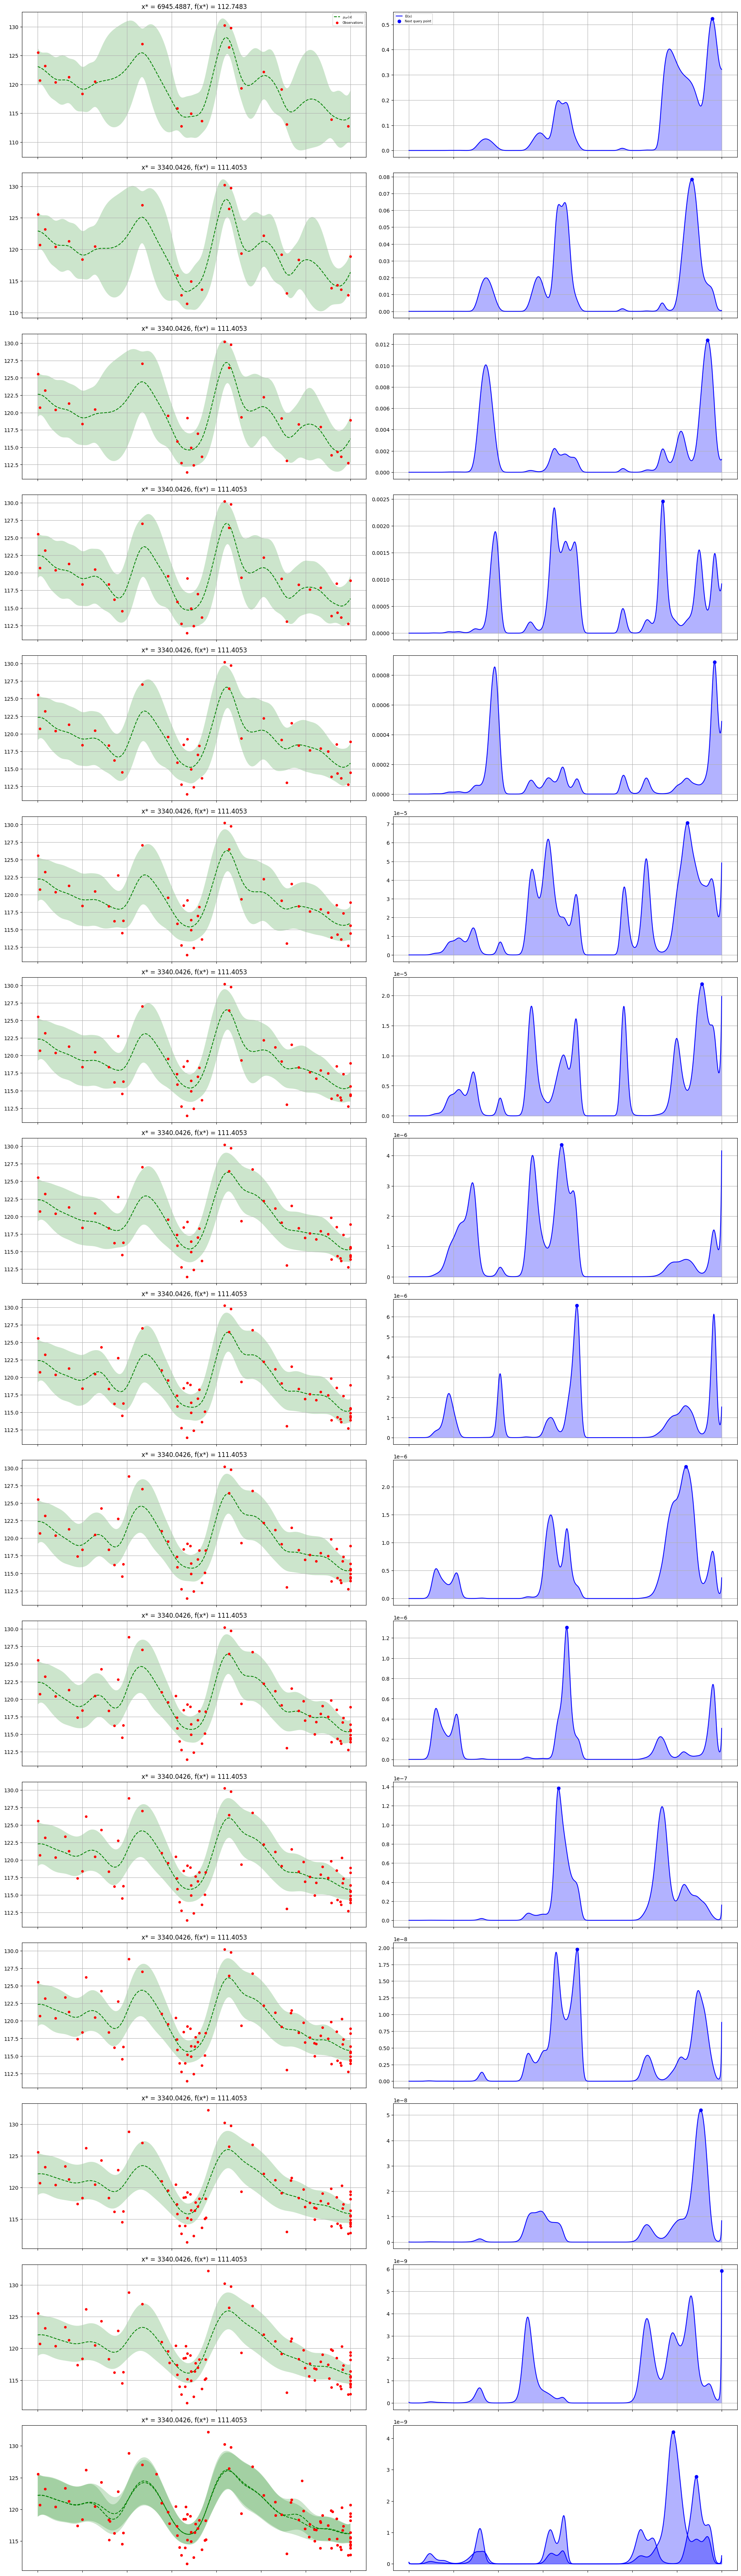

In [42]:
n_events = int(1e6)

fig = plt.figure(figsize=(20, 80))

itrs = 100

for i in range(itrs):

    if i % 10 == 0:
        print(f'Iteration number {i + 1}')
    
    next_x = opt_gp.ask()
    f_val = objective(next_x, n_events, refs, np.sum)
    res = opt_gp.tell(next_x, f_val)
    
    if (i >= n_initial_points) * (((i - n_initial_points) % 5 == 0) + (i == (itrs - 1))):
    
        plot_optimizer(res, n_iter=(i - n_initial_points) // 5,
                       max_iters=(itrs - n_initial_points) // 5 + 1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Stability check

In [37]:
params_vals = np.linspace(0, 7000, 10)

In [38]:
n_events = int(1e6)

dots = []

for val in params_vals:

    for i in range(10):

        dots.append((val, objective([val], n_events, refs, np.sum)))

100%|██████████| 1000000/1000000 [02:13<00:00, 7477.26it/s]


In [39]:
dots = np.array(dots)

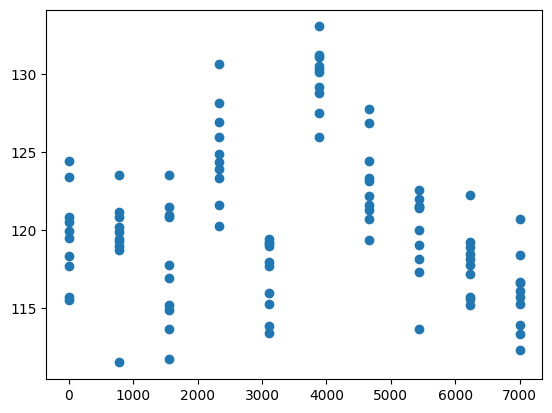

In [40]:
plt.scatter(dots[:, 0], dots[:, 1])